# IMDB SENTIMENT ANALYSIS

## Introduction

**Sentiment analysis** is a subject that is one of the most targeted applications in NLP and with interesting applications in everyday life.

For this task, we will use the IMDB Dataset database, available from kaggle [at this address](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The dataset contains 50000 *reviews* of different films, with each review classified as positive or negative. As it is a dataset with a label for each sentence and with only two possible classes for this label, we can say that we are dealing with a binary classification task for texts.

A Word2Vec model was formulated to generate Word Embeddings used as input to two different neural network architectures for text classification - CNN and LSTM - for comparison purposes.

We started by importing the libraries used throughout this work and defining *seeds* to make the work as reproducible as possible.

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import pad_sequences
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.models import word2vec
from gensim.test.utils import datapath
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from numpy.random import seed
import tensorflow as tf
import logging
from sklearn.metrics import classification_report
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

seed(1)
tf.random.set_seed(2)

## Data Preprocessing

One of the most important parts in any NLP task - and in data science as a whole - is the data pre-processing, in order to make data more "clean" and interpretable by the networks architectures.

Having imported the necessary libraries, we read the data file and quickly visualize the first lines, check if there is any null value for removal and print the *shape* of the dataframe.

In [2]:
data = pd.read_csv('./IMDB_Dataset.csv')
print(data.isnull().values.any())
print(data.shape)
print(data.head())

False
(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Then we visualize one of the *reviews* - the first one - just to get an idea of the possible preprocessing jobs that can be done. We also print the number of *reviews* classified as positive and negative.

In [3]:
print(data.iloc[1, 0])
data.groupby('sentiment').count()

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


,review
sentiment,
negative,25000
positive,25000


First, the equality in the division of *reviews* according to classes is highlighted. This is because Kaggle's dataset is only a representative sample of the original dataset (which contains more *reviews*) thus maintaining a balance between classes that saves us from having to deal with problems of unbalanced classes.

Then we create a function with the preprocessing operations used. The code provides comments about each operation.

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def preprocess_text(sen):
  # Removing html tags
  sentence = re.sub('<[^>]+>', '', sen).lower()

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  # Removing abreviated verbs
  sentence = re.sub("\'ll", ' will', sentence)
  sentence = re.sub("\'ve", ' have', sentence)
  sentence = re.sub("\'s", ' is', sentence)

  # Removing stopwords
  sentence = remove_stopwords(sentence)

  # Lematize words
  # word_list = nltk.word_tokenize(sentence)
  # sentence = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

  return sentence

In [6]:
sentences = list(data['review'])
X = [preprocess_text(sen) for sen in sentences]

Applying the chosen pre-processing operations, we have the following sentence as a result - for the case shown above. You can see much smoother text than the original, with all lowercase letters, no links, verb abbreviations (like *We will = We'll*), no presence of *stop words* (like *the*), words of single character or punctuation.

In [7]:
X[1]

'wonderful little production filming technique unassuming old time bbc fashion gives comforting discomforting sense realism entire piece actors extremely chosen michael sheen got polari voices pat truly seamless editing guided references williams diary entries worth watching terrificly written performed piece masterful production great master comedy life realism comes home little things fantasy guard use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating surface terribly'

So far, we have all *reiews* pre-processed but still in sentence form, that is, words. We need to use some kind of numerical identification for each word so that the model can interpret them. To do so, we will use Word2Vec to generate vectors of words, that is, represent each word through an *n*-dimensional vector.

## Word2Vec - Skipgram/CBOW

Let's train a CBOW to generate word vectors. For this task, several parameters were varied in order to try to find the best model defined by solving analogies with the 'question-words.txt' data. Both Skipgram and CBOW were used, with only the *setup* with the best result being presented in this code.

It should be noted that although the objective of this work is not to solve analogies and the database does not contain all the words that the 'question-words' file contains, the method can still be used to assess whether or not the trained model generates vectors of words that preserve the semantic relations among themselves.

PARAMETERS TESTED:
- Array size (num_features) = (100, 150, 200 and 500)
- Window (window) = (5, 10, 15, 20)
- Min_count = (1, 3, 6, 9, 12)
- Negative sampling = (0, 5)
- Ns_exponent: We do not vary this parameter, leaving it at the *default* value of the original paper.
- sg = 0 for CBOW / 1 for Skipgram

In [8]:
sentences = []
for sentence in X:
  foo = sentence.split()
  sentences.append(foo)

In [9]:
context_size = 10
min_word_count = 1
num_features = 100
num_workers = 4
negative = 0
hs = 1
expoent = 0.75
sg = 0

model_word2vec = word2vec.Word2Vec(sentences, sg=sg, vector_size=num_features, window=context_size, min_count=min_word_count, workers=num_workers,
                                   sorted_vocab=1, negative=negative, seed=1, ns_exponent=expoent, hs=hs)

2023-06-21 01:49:53,785 : INFO : collecting all words and their counts
2023-06-21 01:49:53,785 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-06-21 01:49:53,979 : INFO : PROGRESS: at sentence #10000, processed 1029215 words, keeping 51874 word types
2023-06-21 01:49:54,156 : INFO : PROGRESS: at sentence #20000, processed 2058239 words, keeping 69046 word types
2023-06-21 01:49:54,340 : INFO : PROGRESS: at sentence #30000, processed 3087226 words, keeping 81513 word types
2023-06-21 01:49:54,526 : INFO : PROGRESS: at sentence #40000, processed 4114778 words, keeping 91946 word types
2023-06-21 01:49:54,730 : INFO : collected 101065 word types from a corpus of 5146984 raw words and 50000 sentences
2023-06-21 01:49:54,731 : INFO : Creating a fresh vocabulary
2023-06-21 01:49:55,026 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 101065 unique words (100.0%% of original 101065, drops 0)', 'datetime': '2023-06-21T01:49:55.026804', 'g

In [10]:
X_word2vec = model_word2vec.wv.key_to_index
embedding_matrix = model_word2vec.wv.vectors

To start evaluating the performance of the model, we print the words most similar to the word *queen*.

In [11]:
model_word2vec.wv.most_similar('queen')

[('princess', 0.5960198044776917),
 ('aaliyah', 0.5180010795593262),
 ('blond', 0.5145314931869507),
 ('internecine', 0.4841921925544739),
 ('monarch', 0.4653262794017792),
 ('gedren', 0.4603918790817261),
 ('sheeba', 0.4564395546913147),
 ('tarn', 0.45639118552207947),
 ('mab', 0.4541601240634918),
 ('hottie', 0.4501498341560364)]

We also analyzed the ability to perform operations with vectors using the classic operation `KING + WOMAN - MAN`, which should result in `QUEEN`. We note that the generated model, even if it does not point out the correct answer as the most similar, contains it among the 3 most similar.

In [12]:
# printamos os 3 primeiros resultados (nem sempre QUEEN é o primeiro)
model_word2vec.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)

[('queen', 0.5727253556251526),
 ('togther', 0.4883419871330261),
 ('boleyn', 0.4720785319805145)]

Some similarities performance check using *questions-words.txt* file.

In [13]:
similarities = model_word2vec.wv.evaluate_word_analogies(datapath('./questions-words.txt'))

2023-06-21 01:50:16,640 : INFO : Evaluating word analogies for top 300000 words in the model on c:\Users\phara\anaconda3\lib\site-packages\gensim\test\test_data\./questions-words.txt
2023-06-21 01:50:17,847 : INFO : capital-common-countries: 5.8% (27/462)
2023-06-21 01:50:20,710 : INFO : capital-world: 2.4% (27/1124)
2023-06-21 01:50:21,027 : INFO : currency: 0.0% (0/128)
2023-06-21 01:50:26,313 : INFO : city-in-state: 0.6% (13/2056)
2023-06-21 01:50:27,284 : INFO : family: 35.5% (135/380)
2023-06-21 01:50:29,530 : INFO : gram1-adjective-to-adverb: 2.5% (22/870)
2023-06-21 01:50:31,470 : INFO : gram2-opposite: 0.8% (6/756)
2023-06-21 01:50:34,962 : INFO : gram3-comparative: 10.8% (144/1332)
2023-06-21 01:50:37,762 : INFO : gram4-superlative: 4.2% (47/1122)
2023-06-21 01:50:39,538 : INFO : gram5-present-participle: 14.1% (99/702)
2023-06-21 01:50:43,282 : INFO : gram6-nationality-adjective: 12.3% (178/1445)
2023-06-21 01:50:47,162 : INFO : gram7-past-tense: 13.2% (206/1560)
2023-06-21 0

## Data Preparation

Once the data has been pre-processed in order to designate a pattern for the sentences and the word vectors to be used have been defined, we move on to the data preparation stage for the final models - LSTM and CNN.
In this step, we Tokenize the words of the sentences (*reviews*) in order to assign a unique identifier to each word. We also transform the classes as follows:

- 'positive' = 1
- 'negative' = 0

Also in this step, we perform the *padding* operation that guarantees that all sentences have the same length, which is a prerequisite for networks such as LSTM and CNN.

### Tokenizing

In [14]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, data['sentiment'])))
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

### Analyzing Reviews Length

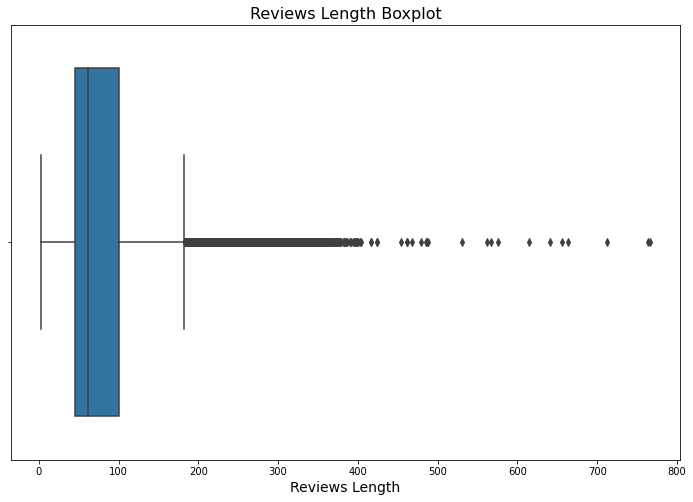

In [15]:
lengths = [len(seq) for seq in X]

plt.figure(figsize=(12, 8))
sns.boxplot(x=lengths)
plt.title('Reviews Length Boxplot', fontsize=16)
plt.xlabel('Reviews Length', fontsize=14)
plt.show()

We note that the vast majority of cases have sentence size less than or equal to 200. Based on the size distribution of *reviews* we can use certain values as maximum size for the *padding* operation.

### Padding/Truncating

The padding task consists of transforming all sentences into sentences of the same length by adding (padding) or removing words (truncation).

For the `MAX_SIZE` hyperparameter, which concerns the size of sentences after padding or truncation, the tested values were:

- `MAX_SIZE` = (200, 300, 500, largest_sentence_size)

As in this work we have a classification for each sentence, applying truncation can remove useful words for classifying the *review* as good or bad. After testing the values described above, it was noted in the end that the best result occurs when we perform only *padding*, that is, when we add words with identifier 0 to lengthen short sentences.

In [16]:
MAX_SIZE = len(max(X, key=len))
# MAX_SIZE = 200
X = pad_sequences(X, padding='pre', maxlen=MAX_SIZE)

### Train, Validation, Test Split

At this point, we have the pre-processed text, with word vectors generated via CBOW and with *padding*. Therefore, we will build the weight matrix to be used in the model, based on the word vectors.

Next, we split the dataset into training, validation, and testing. We used 20% of the data as test data and the remaining 80%, 20% as validation and 80% as training.

In [17]:
import contextlib
emb_matrix = np.zeros((vocab_size, num_features))

for w, i in tokenizer.word_index.items():
  if i < vocab_size:
    with contextlib.suppress(Exception):
      vect = model_word2vec.wv.get_vector(w)
      emb_matrix[i] = vect
  else:
    print('OPA!')
    break

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

## Models

As previously mentioned, we will use two models for comparison regarding *reviews* classification, LSTM and CNN.

In the section of each model architecture, we present a brief description of its operation, followed by the tested hyperparameter values.

### LSTM Architecture

Long short-term memory (LSMT) is a type of recurrent neural network (RNN) architecture with the sequential processing capability transmitting information as a kind of memory. Thus, the network learns not only from the information of each word but also from the sequences of words and their combined meanings.

This feature also makes LSTM networks capable of dealing with the *vanishing gradient* problem that occurs when the weights update is so minimal that the weights end up not being changed for some network units.

Next, we use a Bidirectional layer, thus making the LSTM able to learn from the future information of a certain word, different from a normal LSTM model, which only sees the past information. Simply put, it's like the model is reading everything that comes before AND AFTER each word to learn the meaning of the contexts that contain it.

As our problem consists of a binary classification task, we use the *sigmoid* activation function in the last Dense layer with 1 unit and the *binary_crossentropy* function as *loss*.

Note that the first layer of the model is an Embedding layer with the parameter **trainable == False** and with weights equal to the previously generated embedding matrix. With this configuration we guarantee that the word vectors used by the network are those found via CBOW and will not change.

At this stage, the varied parameters were:

- N_UNITS (LSTM cell size) = 32, 64, 128, 256, 512.
- LEARNING_RATE = 0.0001, 0.0005.

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=num_features, weights=[emb_matrix], trainable=False))
model_lstm.add(Bidirectional(LSTM(128)))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         10106600  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 10,341,353
Trainable params: 234,753
Non-trainable params: 10,106,600
_________________________________________________________________


#### Training

In the training process, only the **batch_size** size was varied in order to avoid *overfitting* in some cases or *underfitting* in others, assigning the **batch_size** that best suited each situation. The values used were:

- BATCH_SIZE = 64, 128, 256.

In [20]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
125/125 [==============================] - 40s 291ms/step - loss: 0.5606 - accuracy: 0.7269 - val_loss: 0.4245 - val_accuracy: 0.8121
Epoch 2/10
125/125 [==============================] - 37s 293ms/step - loss: 0.3854 - accuracy: 0.8318 - val_loss: 0.3578 - val_accuracy: 0.8482
Epoch 3/10
125/125 [==============================] - 36s 289ms/step - loss: 0.3376 - accuracy: 0.8573 - val_loss: 0.3437 - val_accuracy: 0.8601
Epoch 4/10
125/125 [==============================] - 36s 290ms/step - loss: 0.3252 - accuracy: 0.8629 - val_loss: 0.3277 - val_accuracy: 0.8641
Epoch 5/10
125/125 [==============================] - 36s 290ms/step - loss: 0.3088 - accuracy: 0.8719 - val_loss: 0.3067 - val_accuracy: 0.8752
Epoch 6/10
125/125 [==============================] - 36s 291ms/step - loss: 0.2992 - accuracy: 0.8754 - val_loss: 0.3030 - val_accuracy: 0.8779
Epoch 7/10
125/125 [==============================] - 36s 291ms/step - loss: 0.2965 - accuracy: 0.8770 - val_loss: 0.3062 - val_ac

We then plotted the loss function and accuracy graphs during training for the training and validation sets, providing a visual assessment tool for model behavior for both data sets and for the difference in model performance on each case. Thus, we can verify evidence of the existence or not of *overfitting*.

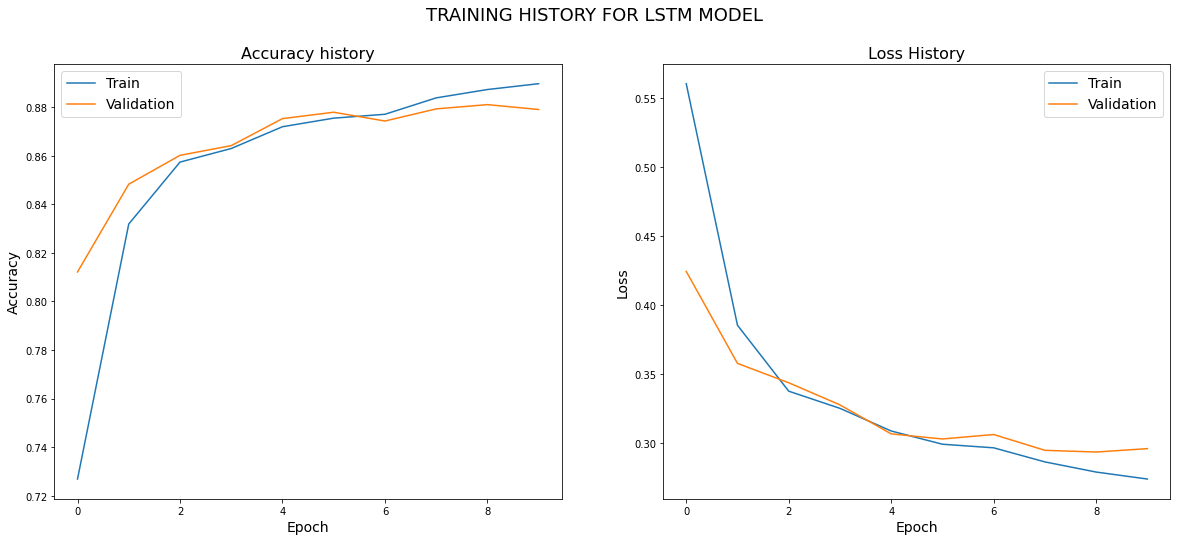

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('TRAINING HISTORY FOR LSTM MODEL', fontsize=18)

ax1.plot(history_lstm.history['accuracy'])
ax1.plot(history_lstm.history['val_accuracy'])
plt.sca(ax1)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=14)
plt.title('Accuracy history', fontsize=16)

ax2.plot(history_lstm.history['loss'])
ax2.plot(history_lstm.history['val_loss'])
plt.sca(ax2)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=14)
plt.title('Loss History', fontsize=16)

plt.show()

#### Testing

Evaluating the performance of the model on the test set.

In [22]:
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

313/313 [==============================] - 13s 41ms/step - loss: 0.2908 - accuracy: 0.8777
Loss: 0.29075247049331665,
Accuracy: 0.8776999711990356


We noticed that the model manages to reach an accuracy of 88% in the test set, which is not far from the performance in the other sets. This shows the good generalization ability of the model trained using the word vectors generated by CBOW.

### CNN Architecture

In this section we use a CNN (Convolutional Neural Network) architecture. CNN-type neural networks are widely used for text and image classification tasks and other applications. Thus, we will use a CNN with a simple architecture and compare the results obtained with those of the LSTM model.

The architecture used here consists of a non-trainable Embedding layer, with weights equal to the embedding matrix calculated with CBOW, followed by a 1D convolution layer - since we are dealing with texts - with a MaxPooling operation that is also 1D. The convolution layer is repeated and we use a 1D GlobalMaxPooling. Finally, a Dense (*fully connected*) layer, with sigmoidal activation and *binary_crossentropy* as a loss function.

The changed parameters and tested values are:

- CNN layer 1: 32, 64, 128.
- CNN layer 2: 64, 128, 256.
- Learning_Rate: 0.0001, 0.0005

Next, the training and testing process presents codes very similar to those of the LSTM methodology.

In [23]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalMaxPooling1D, Flatten

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=num_features, weights=[emb_matrix], input_length=MAX_SIZE, trainable=False))
model_cnn.add(Conv1D(64, 3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D())
model_cnn.add(Conv1D(128, 3, padding='same', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 766, 100)          10106600  
                                                                 
 conv1d (Conv1D)             (None, 766, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 383, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 383, 128)          24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                

#### Training

In [24]:
history_cnn = model_cnn.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
250/250 [==============================] - 8s 25ms/step - loss: 0.6298 - accuracy: 0.6770 - val_loss: 0.4873 - val_accuracy: 0.7793
Epoch 2/10
250/250 [==============================] - 6s 24ms/step - loss: 0.4222 - accuracy: 0.8120 - val_loss: 0.3691 - val_accuracy: 0.8409
Epoch 3/10
250/250 [==============================] - 6s 25ms/step - loss: 0.3511 - accuracy: 0.8498 - val_loss: 0.3334 - val_accuracy: 0.8576
Epoch 4/10
250/250 [==============================] - 6s 25ms/step - loss: 0.3246 - accuracy: 0.8638 - val_loss: 0.3211 - val_accuracy: 0.8641
Epoch 5/10
250/250 [==============================] - 6s 25ms/step - loss: 0.3091 - accuracy: 0.8722 - val_loss: 0.3142 - val_accuracy: 0.8673
Epoch 6/10
250/250 [==============================] - 6s 25ms/step - loss: 0.2977 - accuracy: 0.8766 - val_loss: 0.3081 - val_accuracy: 0.8673
Epoch 7/10
250/250 [==============================] - 6s 25ms/step - loss: 0.2877 - accuracy: 0.8820 - val_loss: 0.3045 - val_accuracy: 0.8689

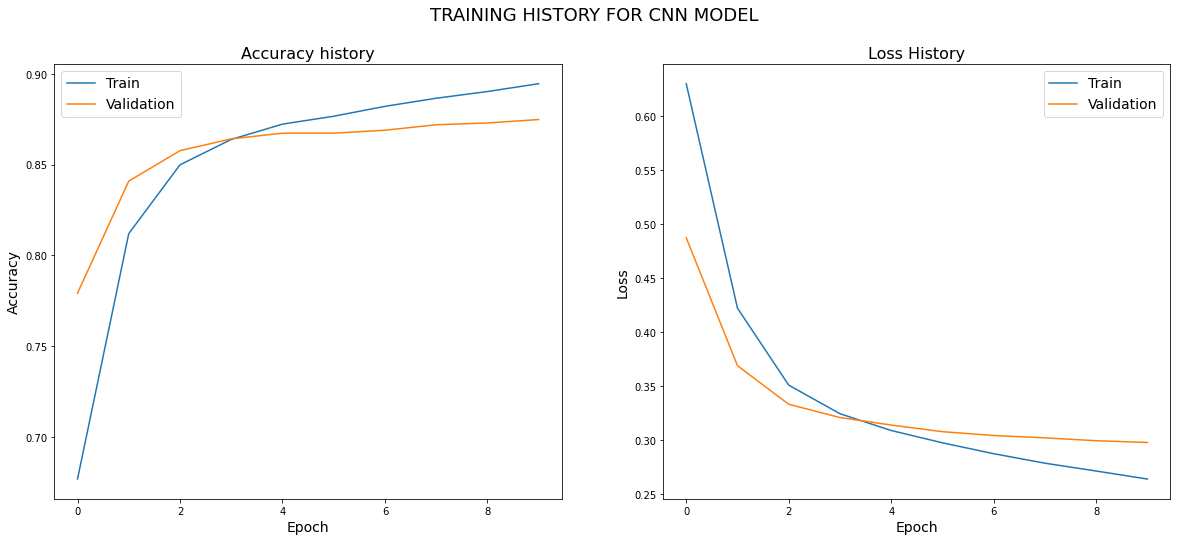

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('TRAINING HISTORY FOR CNN MODEL', fontsize=18)

ax1.plot(history_cnn.history['accuracy'])
ax1.plot(history_cnn.history['val_accuracy'])
plt.sca(ax1)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=14)
plt.title('Accuracy history', fontsize=16)

ax2.plot(history_cnn.history['loss'])
ax2.plot(history_cnn.history['val_loss'])
plt.sca(ax2)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=14)
plt.title('Loss History', fontsize=16)

plt.show()

#### Testing

In [26]:
loss, accuracy = model_cnn.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 0.3007 - accuracy: 0.8716
Loss: 0.300656259059906,
Accuracy: 0.8715999722480774


After training and evaluating the models, we can see that the LSTM, probably due to its sequential processing capability, outperformed the CNN architecture in general. Although the results were very close, it was more difficult to tune the CNN model than for the LSTM case. Still, CNN networks rarely exceeded the accuracy values obtained with an LSTM network for the test bench. CNN also showed a greater tendency to overfit compared to LSTM.

### Comparison

In this section, we plot the confusion matrix of the two fitted models, in order to try to compare their performances. For this, we take the predictions of each model, and define the class based on the given probability. Probabilities greater than 0.5 are classified as 1, ie *review* 'positive', and otherwise are classified as 0, *review* 'negative'.

We then used the **confusion_matrix** function to generate the confusion matrices, and calculated the proportion of each case based on the total. Thus, we have the accuracy per class on the main diagonal of each matrix.

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

pred_lstm = model_lstm.predict(X_test)
pred_lstm = np.where(pred_lstm > 0.5, 1, 0).flatten()
pred_cnn = model_cnn.predict(X_test)
pred_cnn = np.where(pred_cnn > 0.5, 1, 0).flatten()

cmat_lstm = confusion_matrix(y_test, pred_lstm)
cmat_cnn = confusion_matrix(y_test, pred_cnn)

def get_proportion(foo):
  somas = foo.sum(axis=1)
  for i in range(len(foo)):
    for j in range(len(foo)):
      foo.iloc[i,j] = foo.iloc[i,j]/somas[i]
  return foo

cmat_lstm = get_proportion(pd.DataFrame(cmat_lstm))
cmat_cnn = get_proportion(pd.DataFrame(cmat_cnn))

313/313 [==============================] - 1s 2ms/step


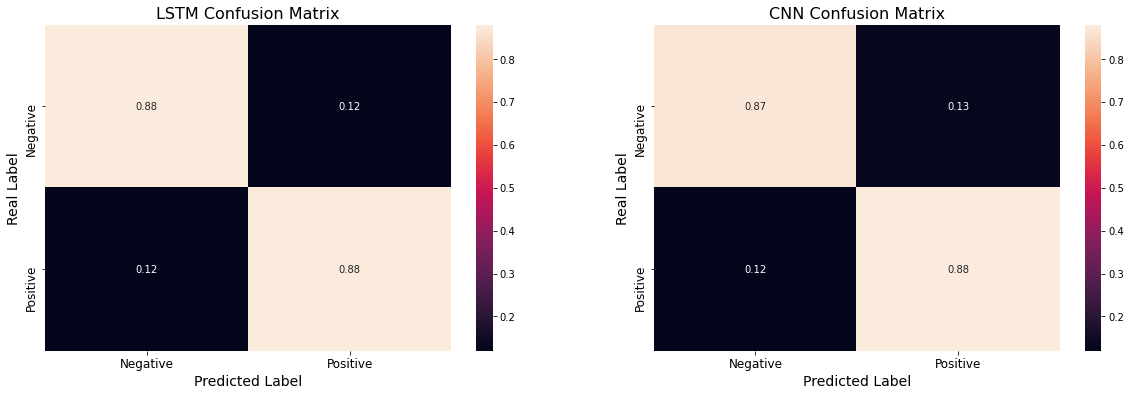

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(cmat_lstm.round(2), annot=True, ax=ax1)
sns.heatmap(cmat_cnn.round(2), annot=True, ax=ax2)

a = list(range(2))
a = [x+0.5 for x in a]

plt.sca(ax1)
plt.title('LSTM Confusion Matrix', fontsize=16)
plt.yticks(a, ['Negative', 'Positive'], fontsize=12)
plt.xticks(a, ['Negative', 'Positive'], fontsize=12)
plt.ylabel('Real Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

plt.sca(ax2)
plt.title('CNN Confusion Matrix', fontsize=16)
plt.yticks(a, ['Negative', 'Positive'], fontsize=12)
plt.xticks(a, ['Negative', 'Positive'], fontsize=12)
plt.ylabel('Real Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

plt.show()

The following code gives us an overview for each case, pointing out both the precision, recall and f1-score metrics. It is possible to notice that the values in general are very close, which indicates that both models are capable of handling the binary sentiment analysis task with close results, and both models presented an F1-score of 87%.

In [29]:
cr_lstm = classification_report(y_test, pred_lstm)
cr_cnn = classification_report(y_test, pred_cnn)
print(cr_lstm)
print(cr_cnn)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Conclusion

After completing this project, it was possible to conclude:

- The use of CBOW to generate vectors of words used as Input of the networks makes the neural model itself easier and faster to train.
- The word vectors generated by CBOW represent the words obtained well, despite the low accuracy for the analogy solution.
- Both models - LSTM and CNN - presented similar result metrics for the binary sentiment analysis task of movie *reviews* (IMDB Dataset).
- Although both models presented similar results, training the CNN was a more laborious process than for the LSTM and most of the time with inferior results.
- The knowledge acquired through the discipline proves to be updated according to the state of the art and more than enough to develop its own applications.